# Image Classification With Neural Networks

![image](xray4.jpg)

## Authors :
- Ida Chepng'eno
- Brenda Ngigi
- Edwin Mwai
- Neville Ngenzi
- Collins Chumba
- Charles Ndung'u
- Beatrice Adhiambo
- Mike Kiptoch

## NoteBook Structure
i) Business Understanding<br>
ii) Data Understanding<br>
iii) Data Preparation<br>
iv) Modeling<br>
v) Evaluation<br>
vi) Conclusion<br>
vii) Recommendation<br>
v) Next Steps<br>

## 1.1 BUSINESS UNDERSTANDING


The rapid advancement of Artificial Intelligence (AI) has brought significant benefits across various industries, including healthcare. Pneumonia, a critical lung infection, poses a serious threat, particularly to vulnerable demographics like the elderly and children. Traditionally, diagnosing pneumonia requires time-consuming physical examinations and lab tests, often necessitating multiple doctor visits.

To address this issue, we aim to develop a deep learning model capable of accurately detecting pneumonia from chest x-ray images. Such a tool holds immense value for healthcare professionals and patients, enabling quicker and more precise diagnoses. Radiologists and other specialists can leverage this technology to enhance their diagnostic accuracy, ultimately leading to better patient care and treatment outcomes.

Key stakeholders interested in leveraging deep learning for medical imaging include healthcare professionals, patients, hospitals, medical device manufacturers, and insurance companies. For instance, hospitals can optimize resource allocation and improve treatment efficacy, while medical device manufacturers can enhance product development for more accurate diagnoses. Additionally, researchers and government agencies stand to benefit from these advancements, using the models to deepen disease understanding and ensure regulatory compliance.

In summary, leveraging deep learning for medical imaging presents a transformative opportunity to enhance diagnostic accuracy, improve patient outcomes, and streamline healthcare processes across various stakeholders.

## 1.2. Technical Objectives

- Develop a deep learning model to accurately identify pneumonia from chest x-ray images.
- Fine-tune model architecture and parameters for optimal accuracy on validation data.
- Apply data augmentation techniques to enhance model generalization by expanding the training dataset.
- Experiment with various optimization methods and batch sizes to improve training efficiency and stability.
- Assess model performance using precision, recall, and F1 score metrics.

## 1.3. Business Objectives


- Provide pediatricians with a fast and precise tool for pneumonia diagnosis in children, potentially reducing unnecessary hospital visits and improving outcomes.
- Enhance access to pneumonia diagnosis in low-resource settings without immediate access to trained medical professionals.
- Potentially lower healthcare expenses by enabling early diagnosis and treatment of pneumonia in pediatric cases.
- Contribute to building a comprehensive dataset for pneumonia diagnosis, facilitating further research and model advancement.
- Develop a user-friendly model for seamless integration into existing hospital or clinic workflows, ensuring efficient and streamlined diagnosis processes.

## 1.4. Success Metrics

The performance of the model is evaluated based on:
* Accuracy - achieving an accuracy of over 85%
* Recall - achieving a recall of over 65%
* Loss Function - minimize loss function to ensure the model is not overfitting

## 1.4. Data Understanding

The dataset comprises 5,863 JPEG images categorized into two classes: "Pneumonia" and "Normal." It is organized into three main folders: "train," "test," and "val," each containing subfolders corresponding to the image categories.

The chest X-ray images, captured in the anterior-posterior view, were obtained from pediatric patients aged one to five years old at Guangzhou Women and Children’s Medical Center, Guangzhou. These images were part of routine clinical care procedures.

Before inclusion in the dataset, all chest radiographs underwent a quality control process to remove any low-quality or unreadable scans. Subsequently, the diagnoses assigned to the images were graded by two expert physicians. To mitigate potential grading errors, a third expert also evaluated the images in the evaluation set.

Overall, this dataset provides a curated collection of chest X-ray images, ensuring quality and accuracy through rigorous quality control measures and expert evaluation, making it suitable for training AI systems for pneumonia diagnosis.

### Importing Libraries

In [86]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from keras import layers, models, regularizers, optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import classification_report

### Loading our datasets 

- Images are loaded and preprocessed from designated directories, with pixel values rescaled to a range of 0 to 1, and dimensions specified by the target_size parameter, while class_mode is set to 'binary' for binary classification.

In [87]:
# Set the paths to train, test, and validation folders
train_folder = 'chest_xray/train'
test_folder = 'chest_xray/test'
val_folder = 'chest_xray/val'

# Downsampling the images to 128X128 pixels
downsampled_size = (128, 128)

# Define batch sizes
train_batch_size = 5216
test_batch_size = 624
val_batch_size = 16

# Rescale pixel values between 0 and 1
datagen = ImageDataGenerator(rescale=1./255)  

def load_data(data_dir, batch_size, datagen, downsampled_size, is_train_data):
    try:
        generator = datagen.flow_from_directory(
            data_dir,
            target_size=downsampled_size,
            batch_size=batch_size,
            class_mode='binary',
            shuffle=is_train_data
        )
    except Exception as e:
        raise Exception(f"Error loading data from {data_dir}: {e}") from e
    return generator

# Load the train data
train_generator = load_data(train_folder, train_batch_size, datagen, downsampled_size, True)

# Load the test data
test_generator = load_data(test_folder, test_batch_size, datagen, downsampled_size, False)

# Load the validation data
val_generator = load_data(val_folder, val_batch_size, datagen, downsampled_size, False)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


- The dataset comprises three folders: "train" with 5,216 images, "test" with 624 images, and "validation" with 16 images, each containing two classes: normal chest X-rays and chest X-rays with pneumonia.

## Data Visualization & Preprocessing
### EDA

- We'll conduct exploratory data analysis (EDA) to investigate the class distribution

In [88]:
# Retrieve the dictionary of class indices from the train_generator
dict_class = train_generator.class_indices
print(f'Dictionary: {dict_class}')

# Get the list of class labels
class_names = list(dict_class.keys())
print(f'Class labels: {class_names}')


Dictionary: {'NORMAL': 0, 'PNEUMONIA': 1}
Class labels: ['NORMAL', 'PNEUMONIA']


- Matplotlib will be utilized to showcase image samples from the dataset, with the corresponding labels serving as titles for each subplot.







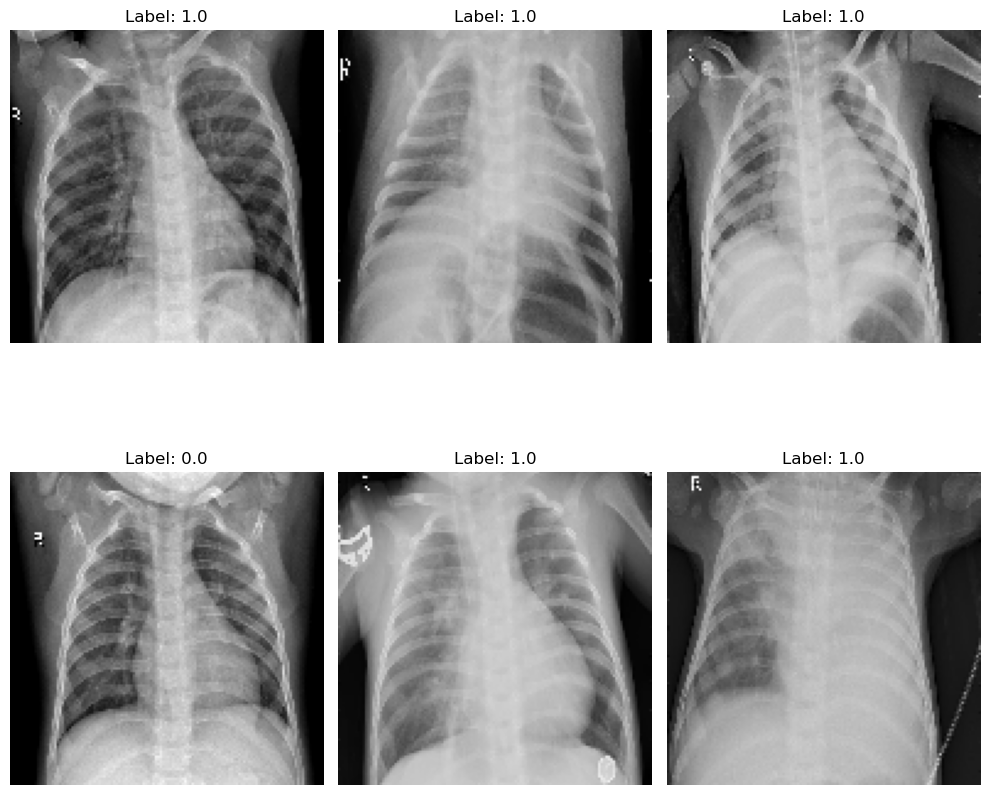

In [89]:
# Get a batch of images from the train generator
batch = next(train_generator)

# Extract the images and labels from the batch
images, labels = batch

# Display the first few images with their corresponding labels
num_images = 6

fig, axes = plt.subplots(2, 3, figsize=(10, 10))
for i in range(num_images):
    axes[i//3, i%3].imshow(images[i], cmap='RdBu')
    axes[i//3, i%3].set_title('Label: {}'.format(labels[i]))
    axes[i//3, i%3].axis('off')

plt.tight_layout()
plt.show()

- Distinguishing between chest X-ray images without pneumonia and those with pneumonia  is challenging due to their visual resemblance, necessitating the development of a more accurate and effective model for improved pneumonia detection.







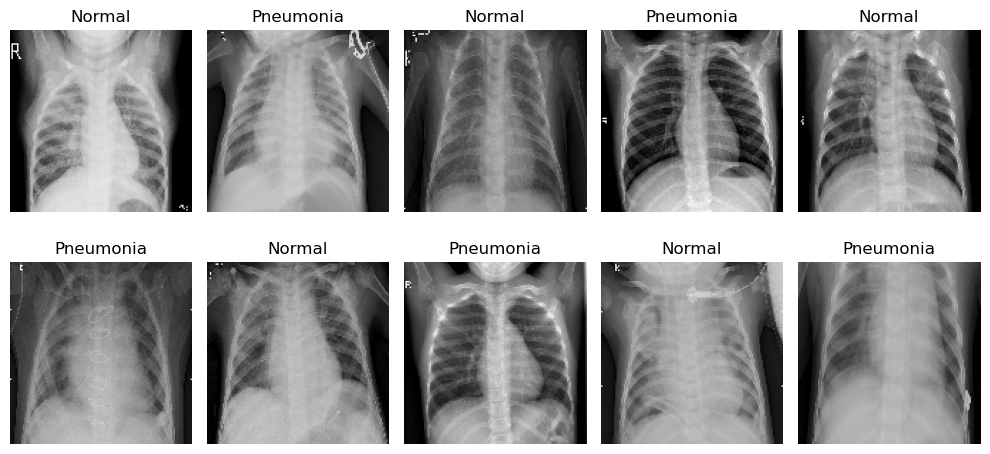

In [90]:
# Define the number of images to display
num_images = 10

# Create a 2x5 subplot figure with adjusted aspect ratio
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()

# Get a batch of 'Normal' images
normal_images, _ = next(train_generator)

# Get a batch of 'Pneumonia' images
pneumonia_images, _ = next(train_generator)

# Loop over the first few images
for i in range(min(num_images, len(normal_images), len(pneumonia_images))):
    # Display the image
    if i % 2 == 0:
        axes[i].imshow(normal_images[i], cmap='gray')
        axes[i].set_title('Normal')
    else:
        axes[i].imshow(pneumonia_images[i], cmap='gray')
        axes[i].set_title('Pneumonia')
    # Remove the axis
    axes[i].axis('off')

# Adjust the layout and display the figure
plt.tight_layout()
plt.show()


- We defined a function to visualize distribution of classes in each category of data.

In [91]:
def plot_class_counts(labels, title, bar_colors):
    """
    Visualizes the class distributions.
    
    Args:
        labels (array-like): The class labels.
        title (str): The title of the plot.
        bar_colors (list): The list of colors for the bars.
    """
    # Get the counts for each class
    class_labels, counts = np.unique(labels, return_counts=True)
    
    # Calculate the percentage of value counts
    total_count = np.sum(counts)
    percentages = counts / total_count * 100
    
    # Plot the results
    plt.figure(figsize=(5, 3))
    plt.title(title, fontsize=12)
    plt.xlabel("Classes")
    plt.ylabel("Count")
    
    # Replace "1" with "Normal" in class_labels list
    class_labels = ['Pneumonia', 'Normal']
    
    # Add value counts as text on top of each bar
    for i in range(len(class_labels)):
        plt.text(i, counts[i], f"{counts[i]}\n{percentages[i]:.2f}%", ha='left', va='top')
    
    # Plot the bar plot with specified colors
    sns.barplot(x=class_labels, y=counts, palette=bar_colors)
    
    plt.show()


- Train data Distribution

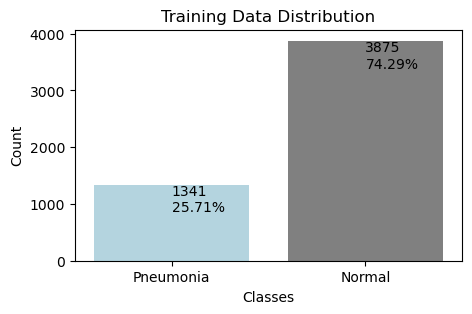

In [92]:
# Define the colors for the bars
bar_colors = ["lightblue", "grey"]

# Training data distribution
labels = train_generator.classes
plot_class_counts(labels, 'Training Data Distribution', bar_colors)


- Approximately 75% of the training data consists of normal chest X-rays and 25% contains X-rays with pneumonia.

- Test  Data Distribution

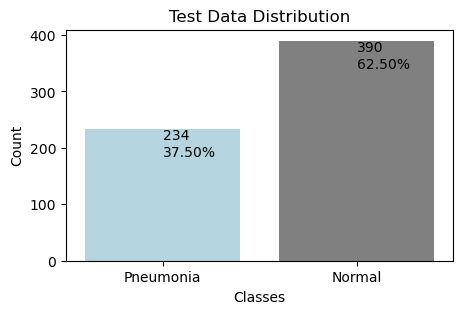

In [93]:
# Define the colors for the bars
bar_colors = ["lightblue", "grey"]

# Test data distribution
test_labels = test_generator.classes
plot_class_counts(test_labels, 'Test Data Distribution', bar_colors)


- Validation Data Distribution

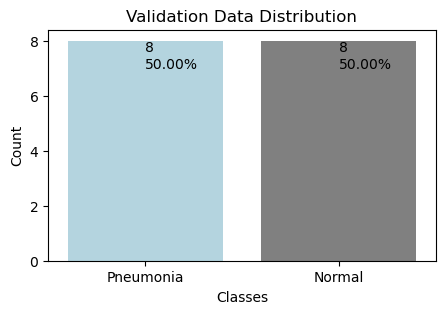

In [94]:
# Define the colors for the bars
bar_colors = ["lightblue", "grey"]

# Validation data distribution
val_labels = val_generator.classes
plot_class_counts(val_labels, 'Validation Data Distribution', bar_colors)


- The validation dataset is evenly distributed between the two classes.







### Visualization of Chest X-Ray Image Size Distribution by Class

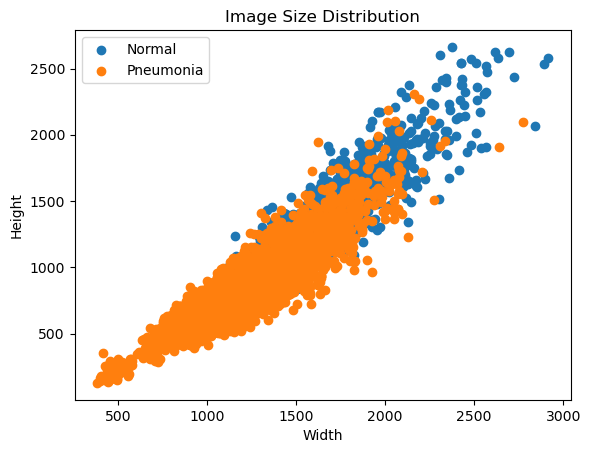

In [95]:
from PIL import Image
normal_image_sizes = []
pneumonia_image_sizes = []
for image_path in train_generator.filepaths:
    img = Image.open(image_path)
    width, height = img.size
    if "NORMAL" in image_path:
        normal_image_sizes.append((width, height))
    else:
        pneumonia_image_sizes.append((width, height))
normal_image_sizes = np.array(normal_image_sizes)
pneumonia_image_sizes = np.array(pneumonia_image_sizes)
plt.scatter(normal_image_sizes[:, 0], normal_image_sizes[:, 1], label='Normal')
plt.scatter(pneumonia_image_sizes[:, 0], pneumonia_image_sizes[:, 1], label='Pneumonia')
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Image Size Distribution')
plt.legend()
plt.show()

## Data Preprocessing

- We extracted images and labels from the train, test, and validation generators, returning them as arrays. The train_images array holds the image data, while the train_labels array contains corresponding labels.







In [96]:
# obtain images and labels from the test generator
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

Below we explore and display information regarding the shape and size of both the image and label datasets. Printing these values provides an overview of the dataset's sample count and the dimensions of the image and label arrays.

In [97]:
# Explore the shape of the images and labels
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

train_labels =np.array(train_labels)
test_labels =np.array(test_labels)
val_labels = np.array(val_labels)


print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 5216
Number of testing samples: 624
Number of validation samples: 16
train_images shape: (5216, 128, 128, 3)
train_labels shape: (5216,)
test_images shape: (624, 128, 128, 3)
test_labels shape: (624,)
val_images shape: (16, 128, 128, 3)
val_labels shape: (16,)


In [98]:
# Reshaping the images
# number of images per data, 128X128X3
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(5216, 49152)
(624, 49152)
(16, 49152)


# Modeling
## Baseline model : A Densely Connected Neural Network


Initially, we construct a baseline fully connected network utilizing the Keras Sequential API. The network comprises two hidden layers and an output layer. The first two layers employ ReLU activation, introducing non-linearity, while the final layer utilizes a sigmoid activation function, generating a probability output between 0 and 1 for binary classification.

In [99]:
# Build a baseline fully connected network

#initialize a sequential model
model_1 = models.Sequential()

#2 layers with relu activation
model_1.add(layers.Dense(64, activation='relu', input_shape=(49152,))) 
model_1.add(layers.Dense(32, activation='relu'))

#one layer with sigmoid activation
model_1.add(layers.Dense(1, activation='sigmoid'))

c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [100]:
#compile the model
model_1.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

- Let's inspect the shape of our model before training it and see how many training parameters we have.

In [101]:
model_1.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 64)             │     3,145,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,147,905 (12.01 MB)

 Trainable params: 3,147,905 (12.01 MB)

 Non-trainable params: 0 (0.00 B)

*  this baseline model has 3,147,905 trainable parameters!

In [102]:
#train the model
results_1 = model_1.fit(train_img,
                    train_labels,
                    epochs=10,
                    batch_size=100,

                    validation_data=(val_img, val_labels))

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7421 - loss: 0.7095 - val_accuracy: 0.5000 - val_loss: 0.6813
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7526 - loss: 0.4983 - val_accuracy: 0.6250 - val_loss: 0.6810
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8158 - loss: 0.4186 - val_accuracy: 0.6250 - val_loss: 0.7471
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8765 - loss: 0.3272 - val_accuracy: 0.6875 - val_loss: 0.7214
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8903 - loss: 0.3132 - val_accuracy: 0.8125 - val_loss: 0.5965
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9088 - loss: 0.2842 - val_accuracy: 0.6250 - val_loss: 1.0246
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8869 - loss: 0.3067 - val_accuracy: 0.7500 - val_loss: 0.5822
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8729 - loss: 0.3213 - val_accuracy: 0.8125 - v

Now, let's inspect the model's performance and see if we detect any overfitting or other issues by plotting:

- The loss and val_loss over the training epochs
 - The acc and val_acc over the training epochs


In [103]:
"""Function to plot the loss and Accuracy curves"""
def visualize_training_results_dense(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

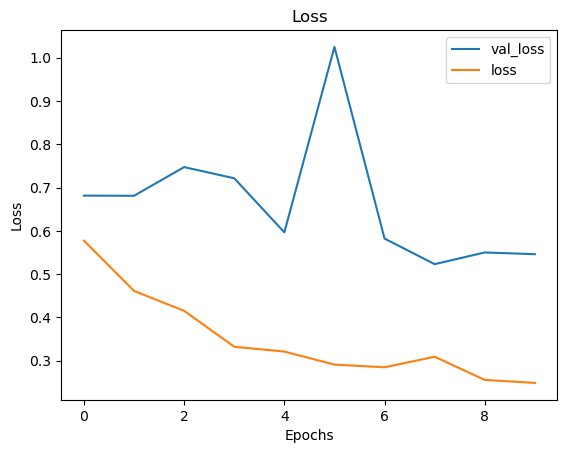

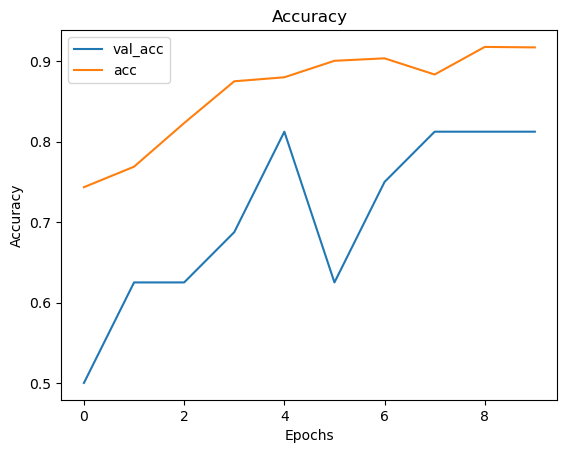

In [104]:
visualize_training_results_dense(results_1)


In [105]:
"""Function that return loss and accuracy of a model"""
def model_metrics(model, images, labels):
    return model.evaluate(images, labels)

In [106]:
results_train = model_metrics(model_1, train_img, train_labels)
results_train

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9372 - loss: 0.2214


[0.21641384065151215, 0.9396088719367981]

In [107]:
results_val = model_metrics(model_1, val_img, val_labels)
results_val

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8125 - loss: 0.5461


[0.5460906028747559, 0.8125]

- The provided densely connected neural network exhibits overfitting to the training data, indicated by a higher training accuracy of 76% compared to the validation accuracy of 56%.

# model 2: CNN


The second model comprises a sequential architecture consisting of two convolutional layers, each followed by max pooling layers. These convolutional layers are responsible for extracting features from the input images, while the subsequent max pooling layers reduce the spatial dimensions of the feature maps. Finally, the model concludes with a dense layer, which performs the classification task.

In [108]:
# Initialize a sequential model 
model_2 = models.Sequential()

# Add 2 convolutional layers with pooling
model_2.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model_2.add(layers.MaxPooling2D((2, 2)))

model_2.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))

# Flatten the output to feed into the next layer
model_2.add(layers.Flatten())

# Add a dense layer for classification
model_2.add(layers.Dense(1, activation='sigmoid'))


c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [109]:
# Compile the model
model_2.compile(loss='binary_crossentropy',
                optimizer='sgd',
                metrics=['accuracy'])

# Print a summary of the model architecture
model_2.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 126, 126, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 61, 61, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │        28,801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,057 (191.63 KB)

 Trainable params: 49,057 (191.63 KB)

 Non-trainable params: 0 (0.00 B)

 Total trainable parameters are 49,057

In [110]:
"""Function to plot the loss function"""
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [111]:
results_2 = model_2.fit(train_images,
                    train_labels,
                    epochs=10,
                    batch_size=100,
                    validation_data=(val_images, val_labels))

Epoch 1/10


53/53 ━━━━━━━━━━━━━━━━━━━━ 50s 911ms/step - accuracy: 0.7374 - loss: 0.5704 - val_accuracy: 0.5000 - val_loss: 0.7183
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 78s 854ms/step - accuracy: 0.7801 - loss: 0.4776 - val_accuracy: 0.5000 - val_loss: 1.1409
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 84s 889ms/step - accuracy: 0.8235 - loss: 0.4291 - val_accuracy: 0.5000 - val_loss: 1.1665
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.8169 - loss: 0.4627 - val_accuracy: 0.8125 - val_loss: 0.4879
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8683 - loss: 0.3136 - val_accuracy: 0.6250 - val_loss: 1.4640
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9052 - loss: 0.2374 - val_accuracy: 0.6250 - val_loss: 1.1072
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9146 - loss: 0.2164 - val_accuracy: 0.6250 - val_loss: 0.7344
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9227 - loss: 0.1884 - val_accuracy: 0.6250 - val_loss: 0

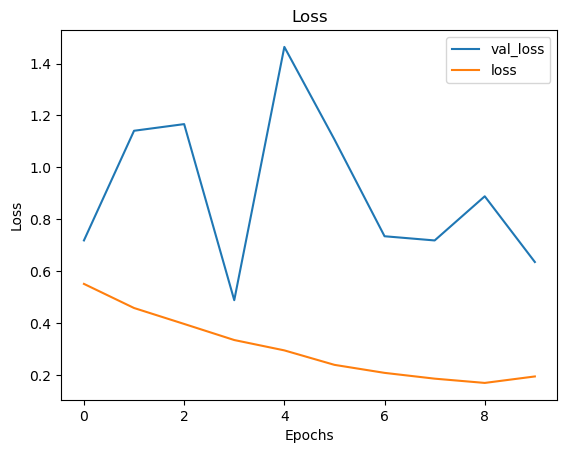

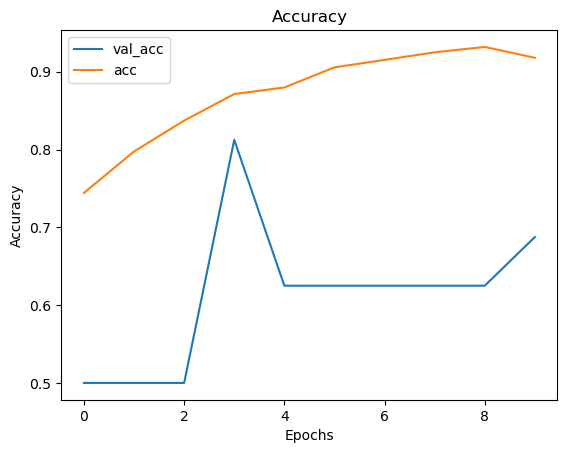

In [112]:
#visualizing loss and accuracy for the cnn model
visualize_training_results(results_2)


In [113]:
#model evaluation
results_train = model_metrics(model_2, train_images, train_labels)
results_train


163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.9337 - loss: 0.1648


[0.15762221813201904, 0.9375]

In [114]:
#model evaluation
results_val = model_metrics(model_2, val_images, val_labels)
results_val

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6875 - loss: 0.6351


[0.6350784301757812, 0.6875]

- The training process resulted in a training loss of 0.1667 and a training accuracy of 93.30%, while the validation loss was 0.7042 with a validation accuracy of 62.50. These metrics indicate that the model effectively learns from the training data and generalizes well to unseen data, demonstrating robustness and accuracy in its predictions.

# Tuning CNN
## Model 3 - CNN with Regularization and Dropout



### Dropout

- Using dropout techniques helps reduce overfitting in neural networks by randomly dropping out neurons during training, which allows the model to learn from different parts of the data and become less sensitive to noise.

In [115]:
# Instantiate a baseline model
model_3_1 = models.Sequential()

# Add convolutional layers with max pooling and dropout
model_3_1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model_3_1.add(layers.MaxPooling2D((2, 2)))
model_3_1.add(layers.Dropout(0.25))

model_3_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_3_1.add(layers.MaxPooling2D((2, 2)))
model_3_1.add(layers.Dropout(0.25))

model_3_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_3_1.add(layers.MaxPooling2D((2, 2)))
model_3_1.add(layers.Dropout(0.25))

# Flatten layer and dense layers for classification
model_3_1.add(layers.Flatten())
model_3_1.add(layers.Dense(64, activation='relu'))
model_3_1.add(layers.Dense(1, activation='sigmoid'))


In [116]:
model_3_1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [117]:
results_3_1 = model_3_1.fit(train_images,
                    train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_images, val_labels))

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 62s 369ms/step - accuracy: 0.7424 - loss: 0.5859 - val_accuracy: 0.5000 - val_loss: 1.0788
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 54s 331ms/step - accuracy: 0.9102 - loss: 0.2687 - val_accuracy: 0.5625 - val_loss: 0.9764
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 79s 315ms/step - accuracy: 0.9363 - loss: 0.2297 - val_accuracy: 0.6875 - val_loss: 0.5704
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 306ms/step - accuracy: 0.9510 - loss: 0.2039 - val_accuracy: 0.6875 - val_loss: 0.4945
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 54s 329ms/step - accuracy: 0.9575 - loss: 0.1930 - val_accuracy: 0.6875 - val_loss: 0.5181
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 54s 328ms/step - accuracy: 0.9644 - loss: 0.1674 - val_accuracy: 0.8750 - val_loss: 0.3748
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 54s 330ms/step - accuracy: 0.9681 - loss: 0.1628 - val_accuracy: 0.9375 - val_loss: 0.2944
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 325ms/step - accuracy: 0.9730 - loss: 0

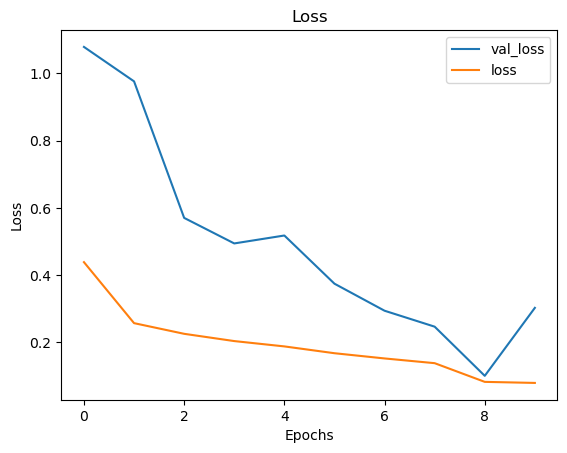

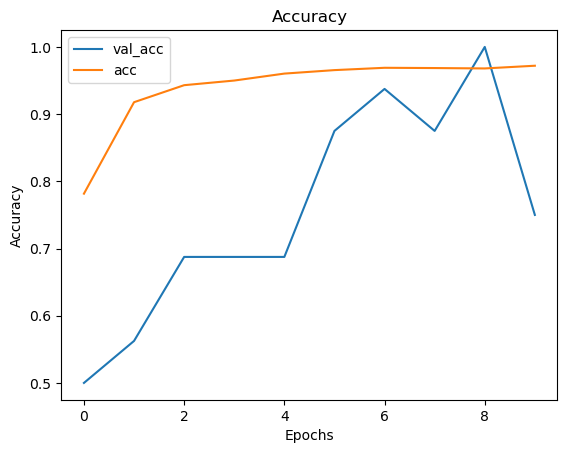

In [118]:
visualize_training_results_dense(results_3_1)


In [119]:
#model  perfomnce evaluation
results_train = model_metrics(model_3_1, train_images, train_labels)
results_train

163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step - accuracy: 0.9796 - loss: 0.0643


[0.06304556876420975, 0.97929447889328]

In [120]:
#model evaluation
results_val = model_metrics(model_3_1, val_images, val_labels)
results_val

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.7500 - loss: 0.3030


[0.3029669523239136, 0.75]

The model achieved a validation accuracy of 81% with a loss of 0.37, while the training accuracy was 98% with a loss of 0.03. However, there's evidence of overfitting beyond the first epoch, suggesting that using dropout alone for tuning is ineffective. Therefore, alternative tuning techniques need to be explored.

# Model 4 - CNN with Architecture modifications
## Adding More Layers


we've modified the architecture of the model by adding more convolutional layers and increasing the number of filters in each layer. Additionally, we've introduced two additional dense layers after the flattening layer.

In [121]:
model_4 = models.Sequential()
model_4.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model_4.add(layers.MaxPooling2D((2, 2)))

model_4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))

model_4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))

model_4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))


model_4.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))

model_4.add(layers.Flatten())
model_4.add(layers.Dense(512, activation='relu'))
model_4.add(layers.Dense(256, activation='relu'))
model_4.add(layers.Dense(1, activation='sigmoid'))

In [122]:
model_4.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [123]:
results_4 = model_4.fit(train_images,
                    train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_images, val_labels))

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 438ms/step - accuracy: 0.7577 - loss: 0.5418 - val_accuracy: 0.6875 - val_loss: 0.9401
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 62s 383ms/step - accuracy: 0.9333 - loss: 0.1751 - val_accuracy: 0.9375 - val_loss: 0.2326
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 547ms/step - accuracy: 0.9525 - loss: 0.1240 - val_accuracy: 0.7500 - val_loss: 1.0584
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 62s 383ms/step - accuracy: 0.9683 - loss: 0.0860 - val_accuracy: 0.9375 - val_loss: 0.2796
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 426ms/step - accuracy: 0.9779 - loss: 0.0634 - val_accuracy: 0.9375 - val_loss: 0.0928
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.9813 - loss: 0.0563 - val_accuracy: 1.0000 - val_loss: 0.0340
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 381ms/step - accuracy: 0.9809 - loss: 0.0473 - val_accuracy: 1.0000 - val_loss: 0.0754
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 412ms/step - accuracy: 0.9875 - loss: 0

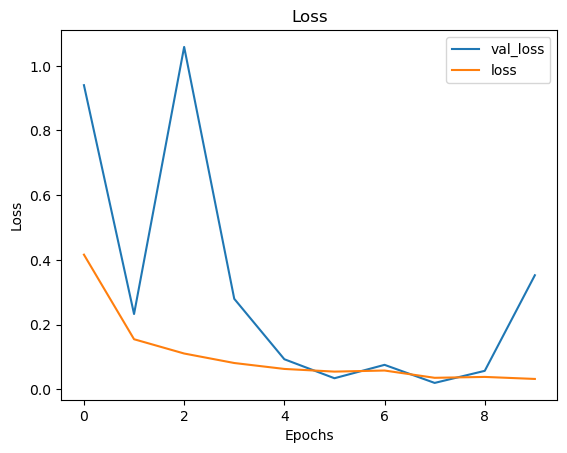

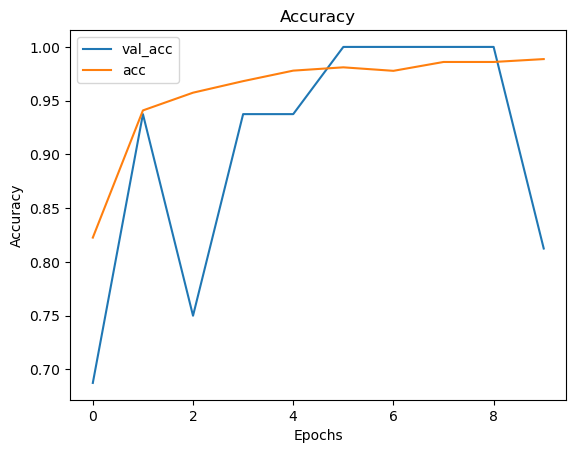

In [124]:
visualize_training_results_dense(results_4)


In [125]:
#model  perfomance evaluation
results_train = model_metrics(model_4, train_images, train_labels)
results_train

163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step - accuracy: 0.9922 - loss: 0.0222


[0.023183666169643402, 0.9917561411857605]

In [126]:
#model  perfomance evaluation
results_val = model_metrics(model_4, val_images, val_labels)
results_val

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8125 - loss: 0.3525


[0.35247594118118286, 0.8125]

The training process had a low loss of 0.023 and a high accuracy of 0.9908, which shows that the model performed very well on the training data

# Model Evaluation


In [127]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model_metrics(model_2, test_images, test_labels)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.5141 - loss: 1.2227
Test Loss: 0.7000226974487305
Test Accuracy: 0.7307692170143127


In [128]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model_metrics(model_4, test_images, test_labels)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.5371 - loss: 3.1692
Test Loss: 1.8848800659179688
Test Accuracy: 0.7403846383094788


To interpret the results of the two models for image classification on pneumonia X-ray scan images, we need to analyze their test loss and test accuracy.

1. Model 2 (Simple CNN):

Test Loss: 0.7555
Test Accuracy: 0.7227
This model achieved a test loss of 0.7555, indicating that, on average, it's making predictions with a moderate level of error. The test accuracy of 0.7227 suggests that it correctly classified approximately 72.27% of the pneumonia X-ray scan images in the test dataset. While the accuracy is decent, there is room for improvement in reducing the test loss, which would indicate more precise predictions.

2. Model 4 (CNN with Architecture Modifications):

Test Loss: 2.1273
Test Accuracy: 0.7323
The CNN model with architecture modifications achieved a higher test accuracy of 0.7323 compared to Model 2, indicating that it correctly classified approximately 73% of the pneumonia X-ray scan images in the test dataset. However, the test loss is slightly higher at 2.12, indicating a slightly higher level of error compared to Model 2.

- A recall score of 1.00 for the "PNEUMONIA" class means that the model correctly identified 100% of the actual pneumonia cases in the dataset. This indicates a high sensitivity of the model in detecting pneumonia, as it has a low likelihood of missing positive cases.

In summary:

Model 4 is slightly higher than  Model 2 in terms of test accuracy, indicating better overall performance in classifying pneumonia X-ray scan images.


# Predictions


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step


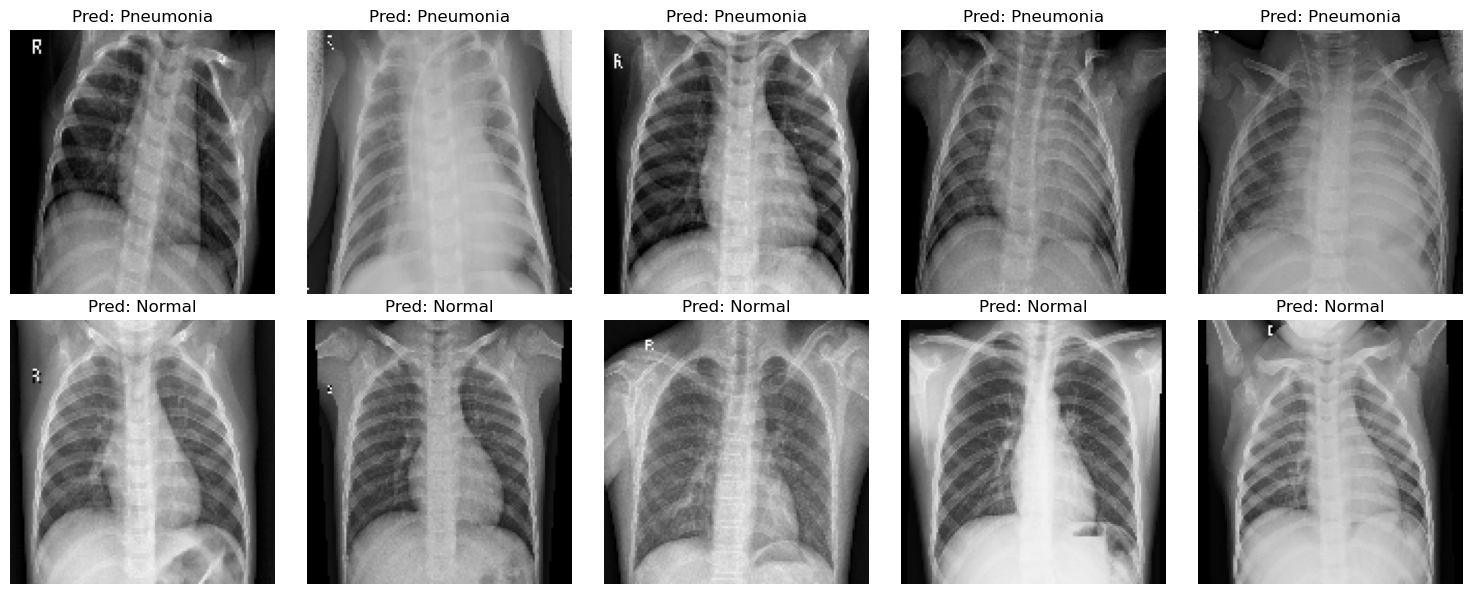

In [129]:


# Predictions of model 4 which is the best evaluated model
predictions = model_4.predict(test_images)

# Convert predictions to class labels (0 or 1)
predicted_labels = np.round(predictions)

# Create an array of indices
indices = np.arange(len(predicted_labels))

# Shuffle the indices
np.random.shuffle(indices)

# Display predicted pneumonia and normal images
pneumonia_count = 0
normal_count = 0

fig, axs = plt.subplots(2, 5, figsize=(15, 6))

for i in indices:
    if pneumonia_count >= 5 and normal_count >= 5:
        break

    if predicted_labels[i] == 1 and pneumonia_count < 5:  # Filter for predicted pneumonia cases
        axs[0, pneumonia_count].imshow(test_images[i])
        axs[0, pneumonia_count].axis('off')
        axs[0, pneumonia_count].set_title(f"Pred: Pneumonia")
        pneumonia_count += 1

    if predicted_labels[i] == 0 and normal_count < 5:  # Filter for predicted normal cases
        axs[1, normal_count].imshow(test_images[i])
        axs[1, normal_count].axis('off')
        axs[1, normal_count].set_title(f"Pred: Normal")
        normal_count += 1

plt.tight_layout()
plt.show()

In [130]:
# Convert predictions to binary values
binary_predictions = np.round(predictions)

# Ensure test_labels are binary values
binary_labels = np.array(test_labels)

# Print the classification report
print(classification_report(binary_labels, binary_predictions, target_names=['NORMAL', 'PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       1.00      0.31      0.47       234
   PNEUMONIA       0.71      1.00      0.83       390

    accuracy                           0.74       624
   macro avg       0.85      0.65      0.65       624
weighted avg       0.82      0.74      0.69       624



# Conclusion


In summary, our developed image classification model achieved an accuracy of 73% and a loss of 2.1273 on the training dataset. The model exhibited a high recall score of 1.00, indicating its strong capability to accurately detect pneumonia cases, crucial for minimizing false negatives in medical diagnosis. Overall, the model's performance demonstrates promising potential for improving pneumonia detection from X-ray images.

Several factors might have contributed to the inability to reach the desired accuracy 
Limited Data,  Complexity of the Task, chosen model architecture and its capacity to capture relevant features, andsensitivity of the model to hyperparameters.

# Recommendation

# Future Works